In [44]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
polish_companies_bankruptcy = fetch_ucirepo(id=365)
features = polish_companies_bankruptcy.data.features
target = polish_companies_bankruptcy.data.targets

In [3]:
features.head()

,year,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64
0,1,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,...,348690.0,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277
1,1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,...,2304.6,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870
2,1,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,...,6332.7,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078
3,1,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,...,20545.0,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497
4,1,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,...,3186.6,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980


In [4]:
target.head()

,class
0,0
1,0
2,0
3,0
4,0


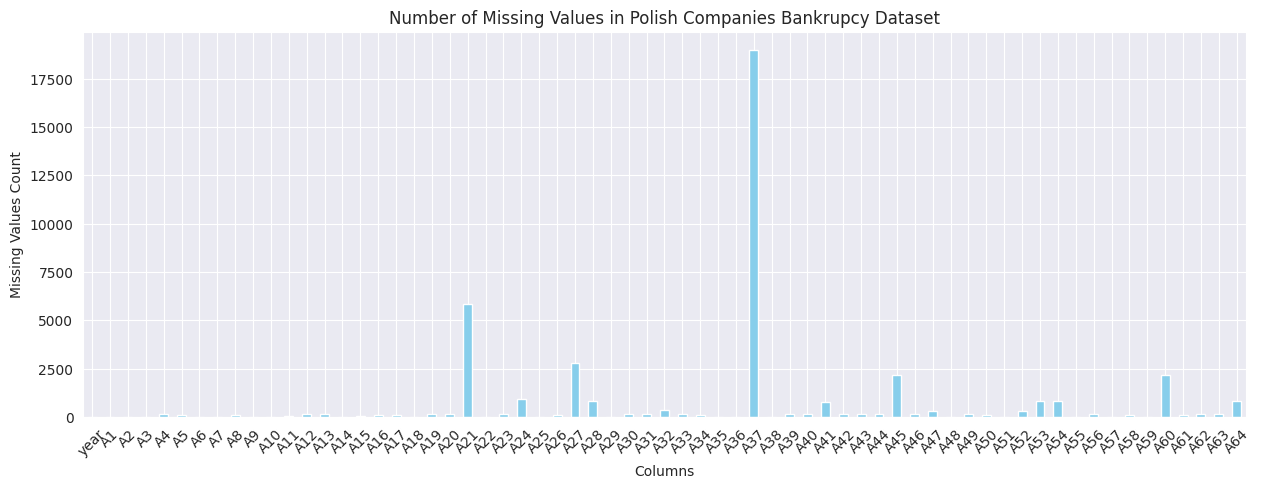

In [6]:
null_counts = features.isnull().sum()
plt.figure(figsize=(15, 5))
null_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Missing Values in Polish Companies Bankrupcy Dataset')
plt.xlabel('Columns')
plt.ylabel('Missing Values Count')
plt.xticks(rotation=45)
plt.show()

In [7]:
target.isnull().sum()

class    0
dtype: int64

In [8]:
data = pd.concat([features, target], axis=1)
data.head()
print(data.shape)

(43405, 66)


### Ocena zbalansowania zbioru
Jak widać zbiór jest mocno niezbalansowany - liczba przypadków klasy 0 znacznie przewyższa liczbę przypadków klasy 1.

Jest to istotne w przypadku klasyfikacji, gdyż może to spowodować bias modelu w stosunku do liczniejszej klasy.

<Axes: ylabel='class distribution'>

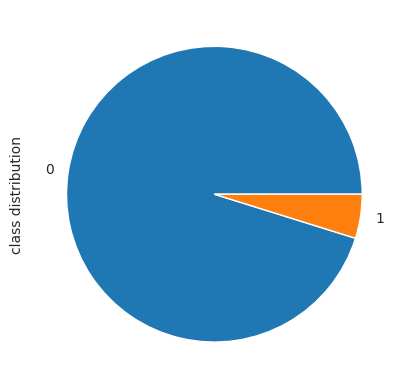

In [9]:
data['class'].value_counts().plot(kind='pie', ylabel="class distribution")


In [11]:
with open("data/raw/polish_bankruptcy.pkl", "wb") as f:
    pickle.dump(data, f)

### Wylistowanie cech o największej wariancji - potencjalne wartości odstające

Text(0, 0.5, 'Variance')

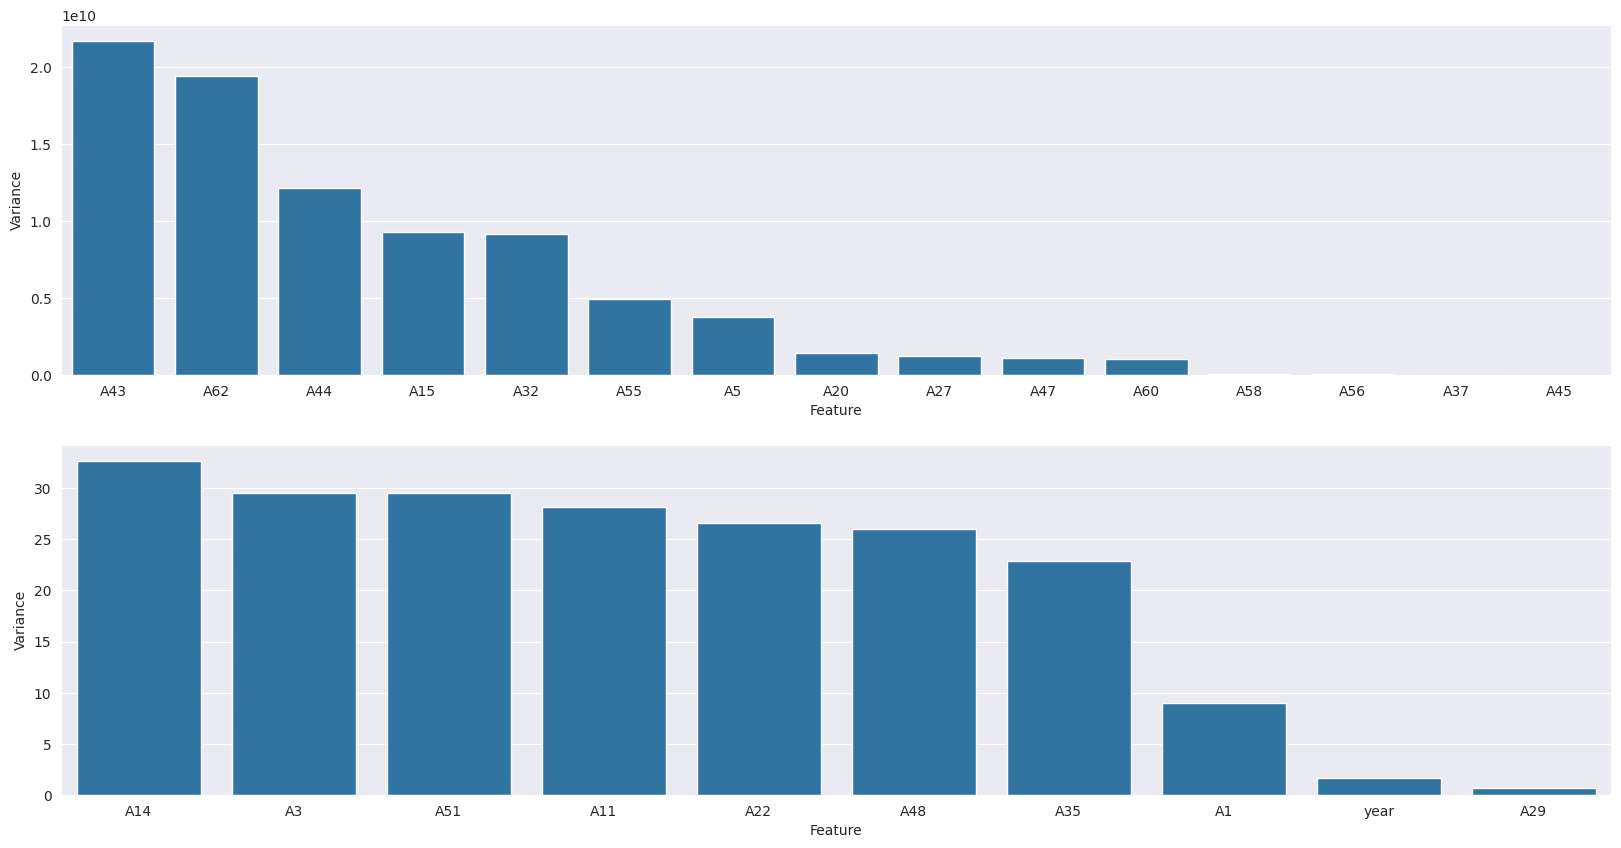

In [12]:
variance = data.var("rows")[:-1]
variance_sorted = variance.sort_values(ascending=False)
x = variance_sorted[:15]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.barplot(x=x.index, y=x.values, ax=ax[0])
ax[0].set_xlabel('Feature')
ax[0].set_ylabel('Variance')
x = variance_sorted[-10:]
sns.barplot(x=x.index, y=x.values, ax=ax[1])
ax[1].set_xlabel('Feature')
ax[1].set_ylabel('Variance')

### Sprawdzenie korelacji między cechami - wysoka korelacja świadczy o redundancji cech, można rozważyć usunięcie jednej z cech silnie skorelowanych

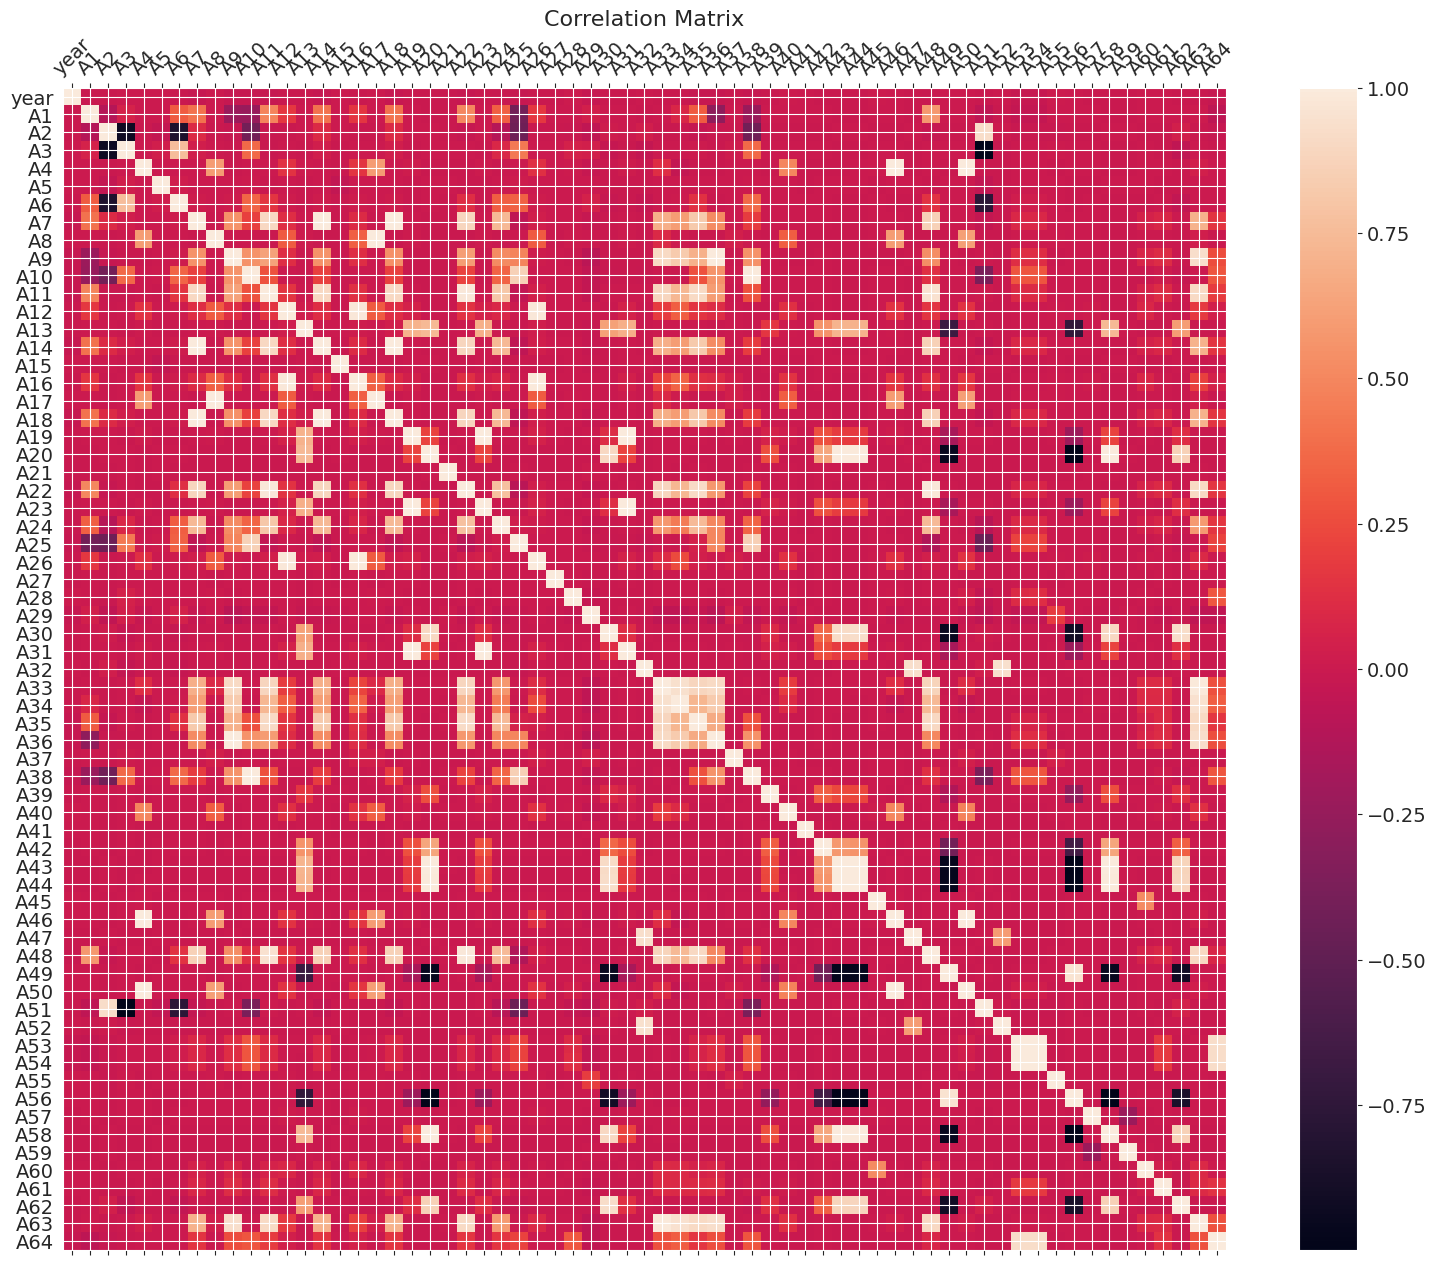

In [13]:
f = plt.figure(figsize=(19, 15))
plt.matshow(features.corr(method="pearson"), fignum=f.number)
plt.xticks(range(features.select_dtypes(['number']).shape[1]), features.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(features.select_dtypes(['number']).shape[1]), features.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Usuwanie nie zostało zastosowane ze względu na późniejszą redukcję wymiarowości z zastosowaniem PCA. Ręczne usuwanie cech nie spowodowało polepszenia metryk modelu oraz nie przyspieszyło znacznie przetwarzania danych.

### Sprawdzenie czy jakaś cecha ma rozkład normalny (istotne przy dalszym przetwarzaniu)

In [11]:
for col in features.columns:
    print("Skewness:", data[col].skew())
    print("Kurtosis:", data[col].kurtosis())

Skewness: 0.03946169552908803
Kurtosis: -1.081827225406298
Skewness: -114.34511038320505
Kurtosis: 15841.665229021624
Skewness: 56.897037750219454
Kurtosis: 5856.4846366616675
Skewness: -81.87625343984931
Kurtosis: 6866.33693559908
Skewness: 155.58221814654618
Kurtosis: 26386.88158615009
Skewness: -171.77556097783253
Kurtosis: 33057.767885891415
Skewness: -29.366974924528765
Kurtosis: 3893.947134493214
Skewness: 18.90251773695248
Kurtosis: 7537.684532700433
Skewness: 77.37057858993019
Kurtosis: 6894.985158003572
Skewness: 109.09124110599764
Kurtosis: 14568.451043564617
Skewness: 48.878549930063414
Kurtosis: 3614.554972078527
Skewness: 53.49458492109462
Kurtosis: 9253.510269862592
Skewness: 54.90650243001229
Kurtosis: 9880.63069777947
Skewness: 118.00309789797328
Kurtosis: 16028.93057275502
Skewness: 18.902512670028
Kurtosis: 7537.684729643637
Skewness: 15.669358870784851
Kurtosis: 6732.576850326062
Skewness: 57.085818775364395
Kurtosis: 9630.195750389892
Skewness: 76.89031072835007
Kur

Niestety żadna cecha nie ma rozkładu normalnego (skośność = 0, kurtoza=3)

### Poniżej próba implementacji (dwie funkcje) Dopasowania do pojęcia klasy (concept closest fit)

https://people.eecs.ku.edu/~jerzygb/b24-miss.pdf

Implementacja nie została zastosowana ze względu na duży nakład obliczeniowy.
TODO: dopracować implementację poprzez zastosowanie operacji macierzowych w celu przyspieszenia obliczeń

In [14]:
def calculate_distance(a, b, max_v, min_v):
    distance = 0
    for i in range(a.size):
        if pd.isnull(a.iloc[i]) or pd.isnull(b.iloc[i]):
            distance += 1
        elif a.iloc[i] == b.iloc[i]:
            distance += 0
        else:
            if not abs(a.iloc[i] - b.iloc[i]):
                print(a.iloc[i], b.iloc[i])
            distance += abs(a.iloc[i] - b.iloc[i]) / abs(max_v.iloc[i] - min_v.iloc[i])
    return distance

In [15]:
def find_lowest_distances(df, index):
    distances = []
    max_v = df.max()
    min_v = df.min()
    for i in index:
        min_dist = np.inf
        idx = 0
        for j, row in df.iterrows():
            if j == i:
                continue
            d = calculate_distance(df.loc[i], row , max_v, min_v)
            if d < min_dist:
                min_dist = d
                idx = j
        distances.append((i, idx))
    return distances

### Wypełnianie brakujących wartości w zbiorze
Zdecydowano się na wypełnianie brakujących wartości za pomocą najczęściej występujących wartości danej cechy (moda) ze względu na najlepsze wyniki.

Moda obliczona jest osobno dla każdej klasy.

In [16]:
def fill_missing(df, class_column):
    for column in df.columns:
        if column == class_column:
            continue
        mode_by_class = df.groupby(class_column)[column].apply(lambda x: x.mode()[0])
        df[column] = df.apply(
            lambda row: mode_by_class[row[class_column]] if pd.isna(row[column]) else row[column],
            axis=1
        )
    return df

In [17]:
data_filled = fill_missing(data, class_column='class')

In [19]:
data_filled.isnull().sum()

year     0
A1       0
A2       0
A3       0
A4       0
        ..
A61      0
A62      0
A63      0
A64      0
class    0
Length: 66, dtype: int64

### Usuwanie duplikatów w celu zmniejszenia ryzyka overfittingu

In [21]:
data_filled.duplicated().sum()

np.int64(401)

In [22]:
data_unique = data_filled.drop_duplicates()
data_unique.shape

(43004, 66)

### Usuwanie wartości odstających
Przetestowane zostały dwa podjeścia do wartości odstających w danych (outliers):
- usuwanie
- przycinanie wartości do górnych i dolnych granic zakresu

Lepsze wyniki modelu uzyskano za pomocą drugiej metody.

Jako metodę wykrywania wartości odstających zastosowano zakres międzykwartylowy (IQR).

In [23]:
def remove_outliers_column_by_class(df, column, class_column, class1, class2):
    class1_data = df[df[class_column] == class1]
    class2_data = df[df[class_column] == class2]

    q1_1 = class1_data[column].quantile(0.25)
    q3_1 = class1_data[column].quantile(0.75)
    iqr_1 = q3_1 - q1_1
    lower_bound_1 = q1_1 - 1.5 * iqr_1
    upper_bound_1 = q3_1 + 1.5 * iqr_1

    q1_2 = class2_data[column].quantile(0.25)
    q3_2 = class2_data[column].quantile(0.75)
    iqr_2 = q3_2 - q1_2
    lower_bound_2 = q1_2 - 1.5 * iqr_2
    upper_bound_2 = q3_2 + 1.5 * iqr_2

    outliers_class1 = class1_data[(class1_data[column] < lower_bound_1) |
                                 (class1_data[column] > upper_bound_1)]
    outliers_class2 = class2_data[(class2_data[column] < lower_bound_2) |
                                 (class2_data[column] > upper_bound_2)]

    all_outliers = outliers_class1.index.union(outliers_class2.index)
    df_clean = df.drop(all_outliers)

    return df_clean

def remove_outliers_by_class(df, columns, class_column, class1, class2):
    data = df.copy(deep=True)
    for col in columns:
        print(f"\nProcessing column: {col}")
        print(f"Initial shape with outliers: {data.shape}")
        print(f"Initial variance by class:")
        print(f"  {class1}: {data[data[class_column] == class1][col].var()}")
        print(f"  {class2}: {data[data[class_column] == class2][col].var()}")

        data = remove_outliers_column_by_class(data, col, class_column, class1, class2)

        print(f"\nAfter removing outliers:")
        print(f"New shape: {data.shape}")
        print(f"New variance by class:")
        print(f"  {class1}: {data[data[class_column] == class1][col].var()}")
        print(f"  {class2}: {data[data[class_column] == class2][col].var()}")

    return data

In [24]:
def clip_outliers_column_by_class(df, column, class_column, class1, class2):
    df_copy = df.copy(deep=True)
    class1_data = df_copy[df_copy[class_column] == class1]
    class2_data = df_copy[df_copy[class_column] == class2]

    q1_1 = class1_data[column].quantile(0.25)
    q3_1 = class1_data[column].quantile(0.75)
    iqr_1 = q3_1 - q1_1
    lower_bound_1 = q1_1 - 1.5 * iqr_1
    upper_bound_1 = q3_1 + 1.5 * iqr_1

    q1_2 = class2_data[column].quantile(0.25)
    q3_2 = class2_data[column].quantile(0.75)
    iqr_2 = q3_2 - q1_2
    lower_bound_2 = q1_2 - 1.5 * iqr_2
    upper_bound_2 = q3_2 + 1.5 * iqr_2

    mask_class1 = (df_copy[class_column] == class1)
    df_copy.loc[mask_class1 & (df_copy[column] < lower_bound_1), column] = lower_bound_1
    df_copy.loc[mask_class1 & (df_copy[column] > upper_bound_1), column] = upper_bound_1

    mask_class2 = (df_copy[class_column] == class2)
    df_copy.loc[mask_class2 & (df_copy[column] < lower_bound_2), column] = lower_bound_2
    df_copy.loc[mask_class2 & (df_copy[column] > upper_bound_2), column] = upper_bound_2

    return df_copy

def clip_outliers_by_class(df, columns, class_column, class1, class2):
    data = df.copy(deep=True)
    for col in columns:
        print(f"\nProcessing column: {col}")
        print(f"Initial shape: {data.shape}")
        print(f"Initial variance by class:")
        print(f"{class1}: {data[data[class_column] == class1][col].var()}")
        print(f"{class2}: {data[data[class_column] == class2][col].var()}")

        data = clip_outliers_column_by_class(data, col, class_column, class1, class2)

        print(f"\nAfter clipping outliers:")
        print(f"Shape remains: {data.shape}")
        print(f"New variance by class:")
        print(f"{class1}: {data[data[class_column] == class1][col].var()}")
        print(f"{class2}: {data[data[class_column] == class2][col].var()}")

    return data

Wartości odstające zostały usunięte dla cech o 11 największych wariancjach.

Usunięto również dwie cechy o najmniejszej wariancji gdyż nie wnoszą dużej wartości do danych przez małe zróżnicowanie wartości.

In [26]:
data_clean = clip_outliers_by_class(data_filled, variance_sorted[:11].index, "class", 0, 1)
data_clean = data_clean.drop(columns=list(variance_sorted[-2:].index))
X = data_clean.iloc[:, :-1]
Y = data_clean.iloc[:, -1]


Processing column: A43
Initial shape: (43405, 66)
Initial variance by class:
0: 22703366436.753994
1: 2824269.862314939

After clipping outliers:
Shape remains: (43405, 66)
New variance by class:
0: 3508.289774924135
1: 5385.839262711525

Processing column: A62
Initial shape: (43405, 66)
Initial variance by class:
0: 20290226864.843094
1: 739902532.8757762

After clipping outliers:
Shape remains: (43405, 66)
New variance by class:
0: 3477.2994829444906
1: 10786.417869188519

Processing column: A44
Initial shape: (43405, 66)
Initial variance by class:
0: 12686669589.09419
1: 1971401.725297571

After clipping outliers:
Shape remains: (43405, 66)
New variance by class:
0: 1345.1472946973165
1: 1830.6727285612142

Processing column: A15
Initial shape: (43405, 66)
Initial variance by class:
0: 9579387311.999628
1: 3253797084.265984

After clipping outliers:
Shape remains: (43405, 66)
New variance by class:
0: 4007131.936841323
1: 23168265.662468728

Processing column: A32
Initial shape: (4

In [27]:
with open("data/processed/polish_bancruptcy_clean.pkl", "wb") as f:
    pickle.dump(data_clean, f)

### Podział na zbiory treningowy i testowy
Podział został wykonany w sposób stratyfikowny, aby proporcje między klasami były jednakowe w obydwu zbiorach.

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(*(X, Y), test_size=0.2, stratify=Y)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(34724, 63)
(34724,)
(8681, 63)
(8681,)


418


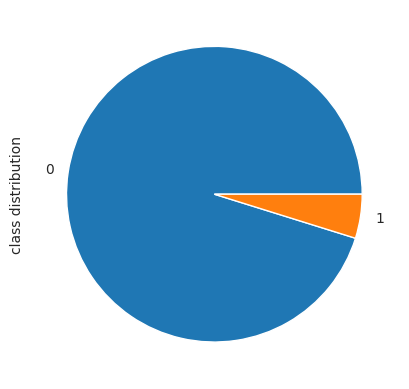

In [30]:
Y_test.value_counts().plot(kind='pie', ylabel="class distribution")
print(Y_test[Y_test == 1].size)

### Skalowanie wartości
Wartości zostały przeskalowane, gdyż niektóre klasyfikatory słabo radzą sobie z uczeniem, gdy różnice między wartościami cech są bardzo duże (np. K-NN classifier).

Również jest to istotne przy stosowaniu redukcji wymiarowości takiej jak PCA, która gorzej radzi sobie, kiedy cechy mają szeroki zakres wartości oraz ich średnia nie znajduje się blisko zera.

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
np.mean(X_train_scaled), np.std(X_train_scaled)

(np.float64(3.1830684830989143e-18), np.float64(1.0000000000000002))

### Redukcja wymiarowości
Stosujemy redukcję wymiarowości, aby zachowane zostało 95 % wariancji. Powoduje to że mamy mniej cech potrzebnych do uczenia modelu, przez co model nauczy się szybciej i osiągnie lepsze metryki klasyfikacji, a jednocześnie zachowane jest 95 % informacji ze zbioru pełnego.

In [33]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
variance_ratio = pca.explained_variance_ratio_
print('Explained variability per principal component: {}'.format(variance_ratio))
print(len(variance_ratio))

Explained variability per principal component: [0.15938209 0.10538923 0.08640993 0.07392433 0.06156612 0.05229319
 0.04426115 0.03562437 0.03322774 0.02969383 0.0227982  0.02162559
 0.01977572 0.01643721 0.01590528 0.01588158 0.01587293 0.01586854
 0.01582708 0.01580587 0.01506192 0.01473874 0.01466377 0.01377184
 0.01193213 0.01111704 0.00974925 0.00904306]
28


Jak widać z 63 cech otrzymujemy 28.

### Klasyfikacja
Do zadania klasyfikacji wykorzystano dwa modele:
- K-NN
- RandomForestClassifier

Klasyfikator K-NN gorzej radzi sobie w przypadku niezbalansowanych danych.

Parametry klasfyikatorów dobrane zostały empirycznie, dokładniejsze badanie parametrów wykonane zostało w notebooku Lab3.

Do ewaluacji modelu zastosowano mocierze pomyłek oraz pełny raport miar precyzji (precission), czułości (recall) oraz miary F1 (F1-score). Dla porównania wyliczono również miarę Accuracy, która nie jest w tym przypadku dobrą metodą ewaluacji modelu. Istotne jest aby zwrócić uwagę na to, że pomimo dużej wartości miary Accuracy, model gorzej radzi sobie przy klasyfikacji klasy mniej licznej. Zdolności modelu znacznie lepiej przedstawia miara F1-Score, a zwłaszcza F1-macro, która uwzględnia wyniki ewaluacji osobno dla obydwu klas, przez co nie tracimy informacji o biasie modelu w kierunku klasy bardziej licznej.

In [34]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train_pca, Y_train)

KNeighborsClassifier(n_neighbors=2)


Test results:

Accuracy: 0.9805321967515264

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8263
           1       0.98      0.61      0.75       418

    accuracy                           0.98      8681
   macro avg       0.98      0.80      0.87      8681
weighted avg       0.98      0.98      0.98      8681



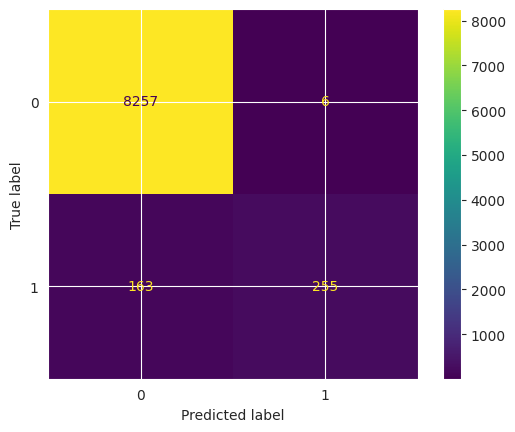

In [35]:
# predictions = model.predict(X_train_pca)
# result = accuracy_score(Y_train_resampled, predictions)
#
# print("\nTrain results:")
# print("\nAccuracy:", result)
# print("\nClassification Report:")
# print(classification_report(Y_train_resampled, predictions))

predictions = model.predict(X_test_pca)
result = accuracy_score(Y_test, predictions)
print("\nTest results:")
print("\nAccuracy:", result)
print("\nClassification Report:")
print(classification_report(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [36]:
model = RandomForestClassifier()
model.fit(X_train_pca, Y_train)

RandomForestClassifier()


Test results:

Accuracy: 0.9839880198133856

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8263
           1       0.99      0.67      0.80       418

    accuracy                           0.98      8681
   macro avg       0.99      0.84      0.90      8681
weighted avg       0.98      0.98      0.98      8681



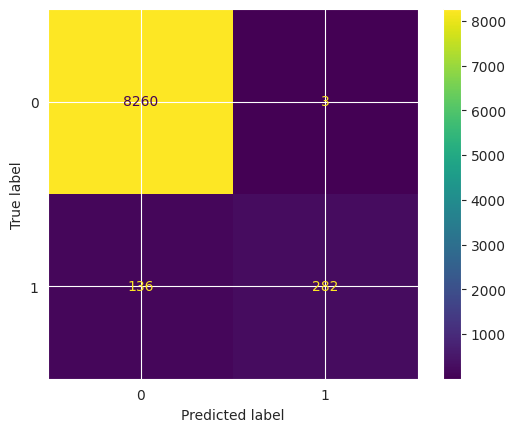

In [37]:
# predictions = model.predict(X_train_pca)
# result = accuracy_score(Y_train_resampled, predictions)
#
# print("\nTrain results:")
# print("\nAccuracy:", result)
# print("\nClassification Report:")
# print(classification_report(Y_train_resampled, predictions))

predictions = model.predict(X_test_pca)
result = accuracy_score(Y_test, predictions)
print("\nTest results:")
print("\nAccuracy:", result)
print("\nClassification Report:")
print(classification_report(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### Rezultaty
Wyniki uzyskane przez modele:
- K-NN: F1-macro 0.87
- Random Forest: F1-macro 0.9

Model Random Forest otrzymał lepsze rezultaty niż model K-NN, gdyż tego typu model lepiej radzi sobie na danych niezbalansowanych.

### Wizualizacja danych

a) dane nieprzetworzone (jedynie usunięte wartości brakujące)

In [40]:
X, _, y, _ = train_test_split(data_filled.iloc[:, :-1], data_filled.iloc[:, -1], test_size=0.2, stratify=target)

In [41]:
start = time.time()
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
end = time.time()
print(tsne.kl_divergence_)
print(f"Execution time: {end - start:.2f} seconds")

1.2475700378417969


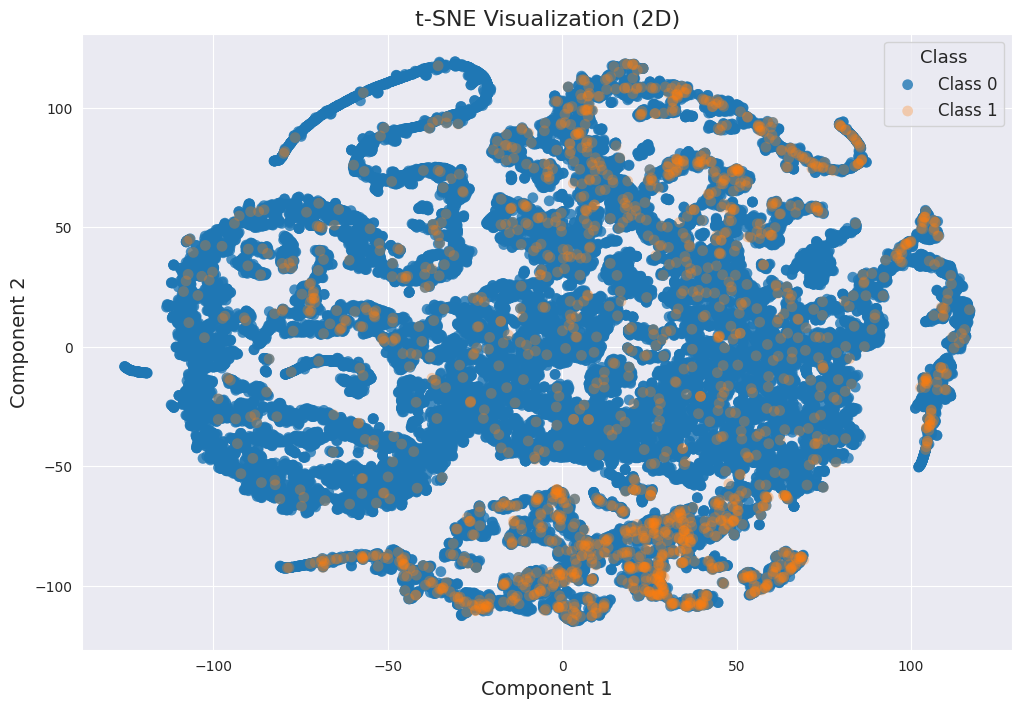

In [48]:
plt.figure(figsize=(12, 8))
classes = np.unique(y)
colors = sns.color_palette('tab10', len(classes))

for idx, cls in enumerate(classes):
    mask = y == cls
    alpha_val = 0.8 if cls == 0 else 0.3
    plt.scatter(
        X_tsne[mask, 0],
        X_tsne[mask, 1],
        label=f'Class {cls}',
        alpha=alpha_val,
        color=colors[idx],
        s=60,
        edgecolor='none'
    )

plt.title("t-SNE Visualization (2D)", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title='Class', fontsize=12, title_fontsize=13)
plt.show()

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [ ]:
plt.figure(figsize=(12, 8))
classes = np.unique(y)
colors = sns.color_palette('tab10', len(classes))

for idx, cls in enumerate(classes):
    mask = y == cls
    alpha_val = 1.0 if cls == 0 else 0.3
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=f'Class {cls}',
        alpha=alpha_val,
        color=colors[idx],
        s=60,
        edgecolor='none'
    )

plt.title("PCA visualization 2D", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title='Class', fontsize=12, title_fontsize=13)
plt.show()

b) przetworzone dane

In [47]:
start = time.time()
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train_scaled)
end = time.time()
print(tsne.kl_divergence_)
print(f"Execution time: {end - start:.2f} seconds")

2.0817503929138184
Execution time: 307.01 seconds


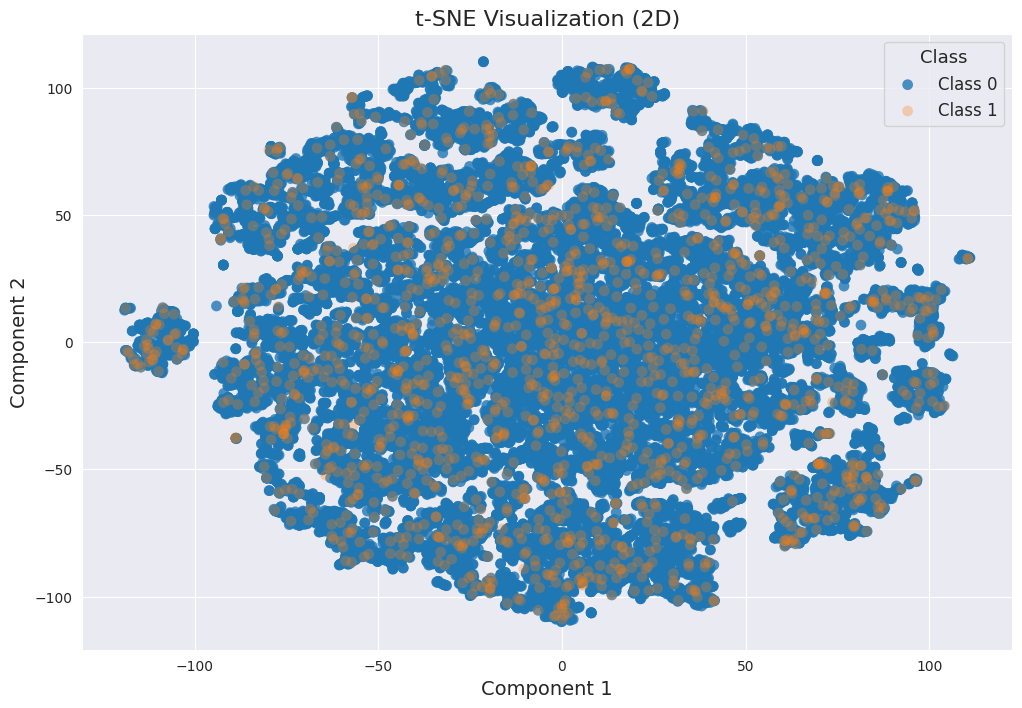

In [49]:
plt.figure(figsize=(12, 8))
classes = np.unique(y)
colors = sns.color_palette('tab10', len(classes))

for idx, cls in enumerate(classes):
    mask = y == cls
    alpha_val = 0.8 if cls == 0 else 0.3
    plt.scatter(
        X_train_tsne[mask, 0],
        X_train_tsne[mask, 1],
        label=f'Class {cls}',
        alpha=alpha_val,
        color=colors[idx],
        s=60,
        edgecolor='none'
    )

plt.title("t-SNE Visualization (2D)", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title='Class', fontsize=12, title_fontsize=13)
plt.show()

In [50]:
pca = PCA(n_components=2)
X_train_pca_vis = pca.fit_transform(X_train_scaled)

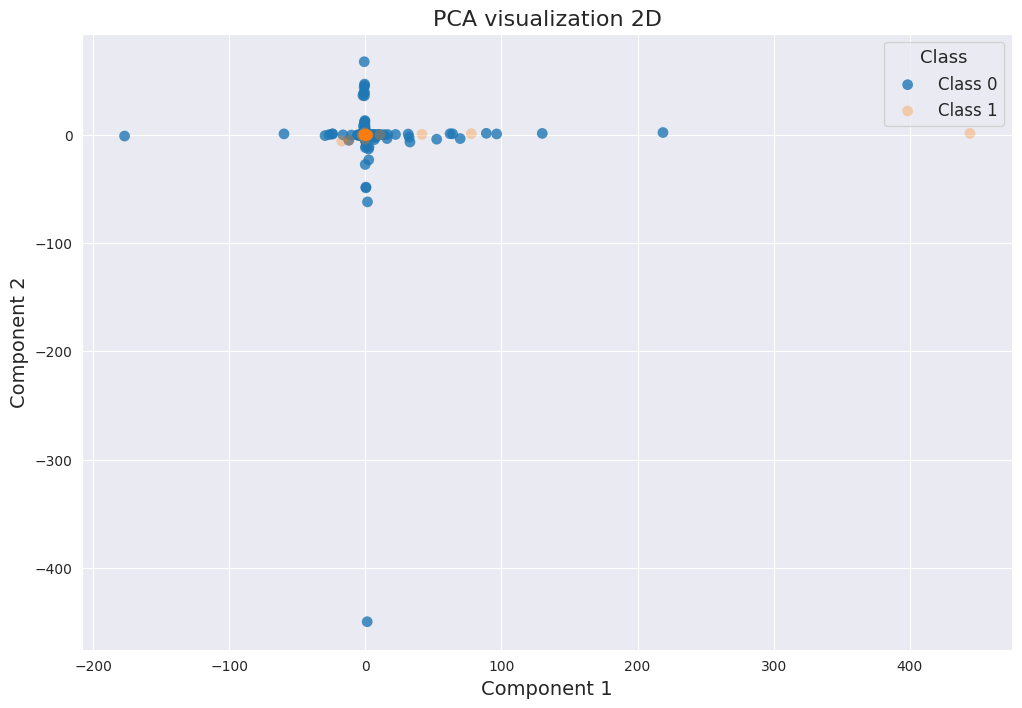

In [53]:
plt.figure(figsize=(12, 8))
classes = np.unique(y)
colors = sns.color_palette('tab10', len(classes))

for idx, cls in enumerate(classes):
    mask = y == cls
    alpha_val = 0.8 if cls == 0 else 0.3
    plt.scatter(
        X_train_pca_vis[mask, 0],
        X_train_pca_vis[mask, 1],
        label=f'Class {cls}',
        alpha=alpha_val,
        color=colors[idx],
        s=60,
        edgecolor='none'
    )

plt.title("PCA visualization 2D", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title='Class', fontsize=12, title_fontsize=13)
plt.show()